## Imports

In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import copy
from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl
import tslib.src.algorithms.tsUtils as tsUtils

## Parameters

In [2]:
N = 100 # Number of individuals per sample group
k = 20 # Number of sample groups
r = 2 # Number of latent variables
t = 100 # Number of time samples
t0 = 70 # Intervention time
# Let M be a k x r x N matrix, where M[a,b,c] represents the ath sample group's bth trait for the ath person.
M = np.zeros((k,r,N))

## Data Generation

In [3]:
# We must also define distribution functions for each sample group.
# For the sake of this experiment, let the two distribution functions be g and h.
# g is a normal distribution with mean = g_mean, stdev = g_stdev.
# f is a lognormal distribution with mean = f_mean, stdev = f_stdev.
# Let the means and stdevs be randomly selected from a linear distribution.
# The coefficients are hardcoded

g_mean = 1 - 2*np.random.random(k)
g_stdev = 0.5*np.random.random(k)
f_mean = 2*np.random.random(k)
f_stdev = 0.3*np.random.random(k)

# Now populate M with the appropriate variables.
mean_a = np.zeros(20)
mean_b = np.zeros(20)

median_a = np.zeros(20)
median_b = np.zeros(20)

for i in range(k):
    M[i,0,:] = np.random.normal(g_mean[i], g_stdev[i], N)
    M[i,1,:] = np.random.lognormal(f_mean[i], f_stdev[i], N)
    mean_a[i] = np.mean(M[i,0,:])
    mean_b[i] = np.mean(M[i,1,:])
    median_a[i] = np.median(M[i,0,:])
    median_b[i] = np.median(M[i,1,:])

In [4]:
# We define a mapping of the latent variables (x,y) to a single value, w. 
# This is hard-coded for now, but these parameters can easily be changed by modifying this funciton.
# We also set the default parameter "z" to be 0. This is for the intervention, which will add an
# additional parameter 'z' to the individuals. 
# Note that f(x,y,0) = f(x,y).
def calculateW(x,y,z=0):
    coef_x = 0.8
    coef_y = 0.2
    coef_z = -0.7
    return coef_x * x + coef_y + y + coef_z * z

In [5]:
# Now, we must define a mapping of the latent variables (x,y) to a single value, w.
# Let us hard-code this mapping as a linear combination of x and y.
# Also define M_prime, a k x N matrix where M[a,b] represents the ath sample group's bth individual's value.

M_prime = np.zeros((k,N))
for i in range(k):
    for j in range(N):
        M_prime[i,j] = calculateW(M[i,0,j], M[i,1,j])

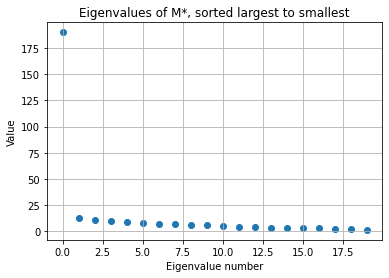

In [6]:
# Let us first verify that this matrix is low rank. 

U, S, V = np.linalg.svd(M_prime)
X = np.arange(20)
plt.title("Eigenvalues of M*, sorted largest to smallest")
plt.xlabel("Eigenvalue number")
plt.ylabel("Value")
plt.scatter(X,S)
plt.grid()
plt.show()

## Intervention & Time increment

In [7]:
# Define new matrix T, which is the time series data.
T = np.zeros((t,k,N))

# Each time increment, we add Gaussian noise for all data.
for i in range(t0):
    for j in range(k):
        for a in range(N):
            T[i,j,a] = calculateW(M[j,0,a],M[j,1,a])
    M = M + np.random.normal(0,0.5,(k,r,N)) # Add noise to latent variables
    
# At time t = t0, we add an intervention for row 0.
# The intervention variables will be sampled from a Gaussian (arbitrary) with mean = -1, stddev = 0.2
intervention_mean = -1
intervention_stdev = 0.2
intervention = np.random.normal(intervention_mean, intervention_stdev, N)
for i in range(t0,t):
    for j in range(k):
        for a in range(N):
            if (j == 0):
                T[i,j,a] = calculateW(M[j,0,a],M[j,1,a],z=intervention[a])
            else:
                T[i,j,a] = calculateW(M[j,0,a],M[j,1,a])
    M = M + np.random.normal(0,0.5,(k,r,N)) # Add noise to latent variables

## Visualize Data

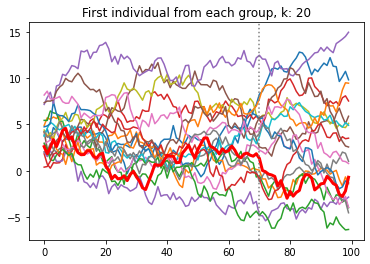

In [15]:
# Let us visualize the trajectory of the first individual from each group (WLOG)
X = np.arange(t)
T0 = T[:,:,0]

T_prime = np.zeros((k,t))
for idx in range(k):
    T_prime[idx,:] = T0[:,idx]

for idx in range(1,k):
    plt.plot(X,T_prime[idx,:])
plt.plot(T_prime[idx,:],color = 'r',linewidth=3)
plt.axvline(x=t0,color='grey',linestyle='dotted')
plt.title("First individual from each group, k: " + str(k))
plt.xlabel = "Time"
plt.ylabel = "W value"
plt.show()

## Verify that matrix is low rank, apply SC

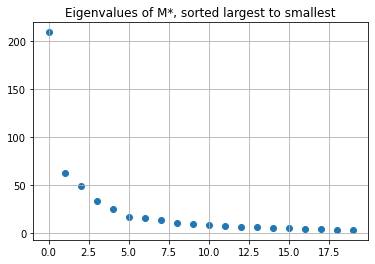

In [16]:
U, S, V = np.linalg.svd(T_prime)
X = np.arange(20)
plt.title("Eigenvalues of M*, sorted largest to smallest")
#plt.xlabel("Eigenvalue number")
#plt.ylabel("Value")
plt.scatter(X,S)
plt.grid()
plt.show()

## RSC

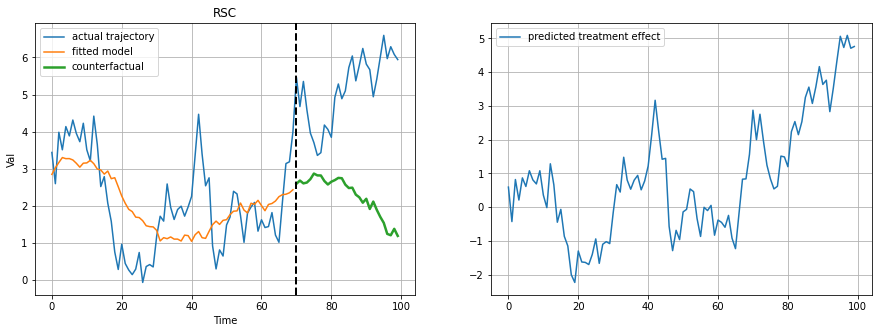

In [34]:
all_trajectories = np.arange(0,k)
donor_trajectories = np.arange(1,k)

trainingTimes = np.arange(0,t0)
testingTimes = np.arange(t0,t)

train_master_dict = {}
train_dict = {}
test_dict = {}

for row in all_trajectories:
    series = T_prime[row]
    train_master_dict.update({row:series[trainingTimes]})

    (trainData, pObservation) = tsUtils.randomlyHideValues(copy.deepcopy(train_master_dict[row]),1)
    train_dict.update({row:trainData})
    test_dict.update({row:series[testingTimes]})
series = T_prime[0]
train_master_dict.update({0:series[trainingTimes]})
train_dict.update({0:series[trainingTimes]})
test_dict.update({0:series[testingTimes]})

train_master_df = pd.DataFrame(data = train_master_dict)
train_df = pd.DataFrame(data = train_dict)
test_df = pd.DataFrame(data = test_dict)
rscModel = RobustSyntheticControl(0,3,len(train_df),probObservation=1.0,modelType='svd',\
                                  svdMethod='numpy',otherSeriesKeysArray=donor_trajectories)
rscModel.fit(train_df)
denoised_df = rscModel.model.denoisedDF()

predictions = np.dot(test_df[donor_trajectories], rscModel.model.weights)
actual = T_prime[0]
model_fit = np.dot(train_df[donor_trajectories][:],rscModel.model.weights)

years = np.arange(0,t)

fig, ax = plt.subplots(1,2)
tick_spacing = 5
years = np.arange(0,t)
fig.set_size_inches(15, 5)

#ax[0].set_xticks(np.arange(t)
#ax[0].set_xticklabels(years, rotation = 45)
#ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax[0].plot(years,actual,label='actual trajectory')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Val')
ax[0].set_title("RSC")
ax[0].plot(trainingTimes,model_fit,label='fitted model')
ax[0].plot(testingTimes,predictions,label='counterfactual',linewidth=2.5)

ax[0].axvline(x=t0,color='k',linestyle='--',linewidth=2)
ax[0].grid()
ax[0].legend()

#ax[1].set_xticks(np.arange(t))
#ax[1].set_xticklabels(years, rotation = 45)
#ax[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#ax[1].set_xlabel('Time')
#ax[1].set_ylabel('Val')
#ax[1].set_title('Treatment Effect')


difference = np.zeros((t))
for idx in trainingTimes:
    difference[idx] = actual[idx] - model_fit[idx]
    
for idx in testingTimes:
    difference[idx] = actual[idx] - predictions[idx-t0]
    
X = np.arange(0,t)
ax[1].plot(X,difference, label='predicted treatment effect')

plt.grid()
plt.legend()
plt.show()